In [1]:
import numpy as np
from pprint import pprint
from copy import deepcopy


from laboneq.contrib.example_helpers.generate_descriptor import generate_descriptor
#from laboneq.contrib.example_helpers.generate_device_setup import generate_device_setup
from laboneq.dsl.device import DeviceSetup
from laboneq.simple import *
from laboneq.dsl.device import DeviceSetup
from laboneq.dsl.calibration import Oscillator, SignalCalibration
from laboneq.dsl.enums import ModulationType




# descriptor = generate_descriptor(
#     #pqsc=[""], # 장비 여러개 사용시
#     shfqc_6=["DEV12256"], 
#     number_data_qubits=3,
#     multiplex=True,
#     number_multiplex=6,
#     include_cr_lines=False,
#     include_ef_lines=True,
#     get_zsync=False,  # Only set to True when using real device
#     save = True,
#     filename="1port",
#     ip_address="192.168.0.83"
# )


#descriptor
#setup = DeviceSetup.from_descriptor(yaml_text=descriptor, server_host="192.168.0.83")
setup = DeviceSetup.from_yaml(filepath="/Users/yalgaeahn/JSAHN/qubit-experiment/examples/selectiveRIP/Descriptors/1port.yaml" , server_host="192.168.0.83")
#setup
setup.instruments[0].device_options = 'SHFQC/PLUS/QC6CH'
#setup.instruments


bus_ids = [f"b{i}" for i in range(3)]
bus_port = [4,5,6] #used 1,2,3 for qubit drive

for i, bus in zip(bus_port,bus_ids):
    setup.add_connections(
        setup.instruments[0].uid,
        # each bus uses its own drive:
        create_connection(
            to_signal=f"{bus}/drive",
            ports=f"SGCHANNELS/{i}/OUTPUT"
        ))

# Calibrate qubit drive/measure lines for oscillator phase increments
qubit_ids = [uid for uid in setup.logical_signal_groups if uid.startswith("q")]
for qubit in qubit_ids:
    for line, frequency, mod_type in [
        ("drive", 5e9, ModulationType.HARDWARE),
        ("drive_ef", 6e9, ModulationType.HARDWARE),
        ("measure", 4e9, ModulationType.SOFTWARE),
    ]:
        logical_signal = setup.logical_signal_by_uid(f"{qubit}/{line}")
        oscillator = Oscillator(modulation_type=mod_type)
        logical_signal.calibration = SignalCalibration(
            local_oscillator=Oscillator(frequency=frequency),
            oscillator=oscillator,
        )
        if line == "measure":
            acquire_signal = setup.logical_signal_by_uid(f"{qubit}/acquire")
            acquire_signal.calibration = SignalCalibration(
                local_oscillator=Oscillator(frequency=frequency),
                oscillator=oscillator,
            )

from qpu_types.fixed_transmon import FixedTransmonQubit, FixedTransmonQubitParameters
from qpu_types.bus_cavity import BusCavity, BusCavityParameters
from qpu_types.fixed_transmon.operations import FixedTransmonOperations
from qpu_types.bus_cavity.operations import BusCavityOperations
from laboneq.dsl.quantum.qpu import QPU, QuantumPlatform
from helper import load_qubit_parameters, save_qubit_parameters

qubit_uids = [uid for uid in setup.logical_signal_groups if uid.startswith("q")]
bus_uids = [uid for uid in setup.logical_signal_groups if uid.startswith("b")]

qubits = FixedTransmonQubit.from_device_setup(
    setup, qubit_uids=qubit_uids)
buses = BusCavity.from_device_setup(
    setup, qubit_uids=bus_uids)

qpu = QPU(quantum_elements={"qubits" : qubits, "bus" : buses}, quantum_operations=[FixedTransmonOperations, BusCavityOperations])


# from laboneq.simple import workflow
# folder_store = workflow.logbook.FolderStore("./experiment_store") 
# folder_store.activate()
# #folder_store.deactivate()
# #workflow.logbook.LoggingStore().activate()
# #workflow.logbook.LogbookStore().deactivate()

import os
from datetime import datetime
def find_latest_json(folder_path):
    files = [f for f in os.listdir(folder_path)]
    timestamps = []
    for file in files:
        try:
            # Extract a timestamp assuming it's included in the filename
            timestamp_str = file.split('_', 1)[0]  # Assuming YYYYMMDDHHMMSS format
            timestamp = datetime.strptime(timestamp_str, '%Y%m%d-%H%M%S')
            timestamps.append((timestamp, file))
        except ValueError:
            print("fuck")
            continue  # Skip files that do not match the timestamp format

       # Find the most recent file
    if timestamps:
        latest_file = max(timestamps, key=lambda x: x[0])[1]
        return os.path.join(folder_path, latest_file)
    return None

qb_pars_file = find_latest_json("./qpu_parameters/")
print(f"LOADED: {qb_pars_file}")

from qpu_types.fixed_transmon.operations import FixedTransmonOperations
from qpu_types.bus_cavity.operations import BusCavityOperations
import laboneq.dsl.quantum.qpu as qpu_mod

class CombinedOperations(FixedTransmonOperations, BusCavityOperations):
    pass

qpu_mod.CombinedOperations = CombinedOperations

qpu = load(qb_pars_file)

buses = qpu.groups.bus
qubits = qpu.groups.qubits


from laboneq.simple import workflow
folder_store = workflow.logbook.FolderStore("./experiment_store")
folder_store.activate()

fuck
LOADED: ./qpu_parameters/20260211-2256_2q_qst


# CONNECTION

In [2]:
from laboneq.simple import Session
session = Session(setup)
session.connect(ignore_version_mismatch=False, do_emulation=False)
#session.disconnect()

[2026.02.12 20:22:34.048] INFO    Logging initialized from [Default inline config in laboneq.laboneq_logging] logdir is /Users/yalgaeahn/JSAHN/qubit-experiment/examples/selectiveRIP/laboneq_output/log
[2026.02.12 20:22:34.050] INFO    VERSION: laboneq 25.10.3
[2026.02.12 20:22:34.050] INFO    Connecting to data server at 192.168.0.83:8004
[2026.02.12 20:22:34.114] INFO    Connected to Zurich Instruments LabOne Data Server version 25.10.1.4 at 192.168.0.83:8004
[2026.02.12 20:22:34.164] INFO    Configuring the device setup
[2026.02.12 20:22:34.284] INFO    The device setup is configured


1. readout frequency sweep → frequency fixed
2. integration window sweep → 고정
3. readout length sweep → 고정
4. frequency sweep (d′ maximize)
5. power sweep (마지막)

# Dispersive Shift

In [ ]:

from experiments import dispersive_shift

#######################################################################
q = qubits[0]
temporary_parameters = {}
temp_pars =deepcopy(q.parameters)
temporary_parameters[q.uid] = temp_pars

print(f"DRIVE range (dBm) : {q.parameters.drive_range}, READOUT range (dBm) : {q.parameters.readout_range_out}")
#######################################################################
options = dispersive_shift.experiment_workflow.options()
options.count(1024)
options.update(False)
#print(workflow.show_fields(options))

###################################################################
dispersive = dispersive_shift.experiment_workflow(
    session=session,
    qpu=qpu,
    qubit=q,
    frequencies=q.parameters.readout_resonator_frequency + np.linspace(-5e6,5e6,201),
    options=options,
    states='ge',
    temporary_parameters=temporary_parameters
)

dispersive_result = dispersive.run() 
print(dispersive_result.tasks['analysis_workflow'].output)

# Readout Frequency Sweep 

[2026.02.12 20:22:38.468] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.12 20:22:38.469] INFO      Workflow 'readout_frequency_sweep': execution started at 2026-02-12           
[2026.02.12 20:22:38.469] INFO      11:22:38.468168Z                                                              
[2026.02.12 20:22:38.469] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.02.12 20:22:38.480] INFO    Task '_resolve_frequencies': started at 2026-02-12 11:22:38.480116Z
[2026.02.12 20:22:38.481] INFO    Task '_resolve_frequencies': ended at 2026-02-12 11:22:38.481079Z
[2026.02.12 20:22:38.481] INFO    Task 'temporary_qpu': started at 2026-02-12 11:22:38.481777Z
[2026.02.12 20:22:38.482] INFO    Task 'temporary_qpu': ended at 2026-02-12 11:22:38.482737Z
[2026.02.12 20:22:38.485] INFO    Task 'temporary_quantum_elements_from_qpu': started at 2026-02-12 
[2026.02.12 20:22:38.485] INFO    11:22:38.485451

NameError: name 'extract_analysis_output' is not defined

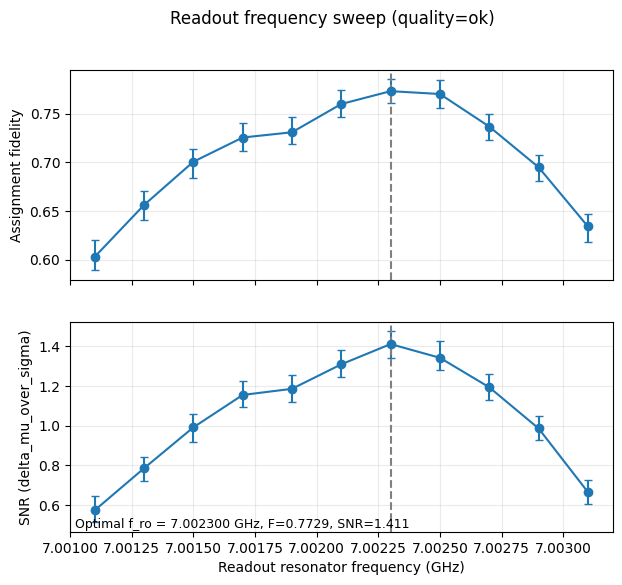

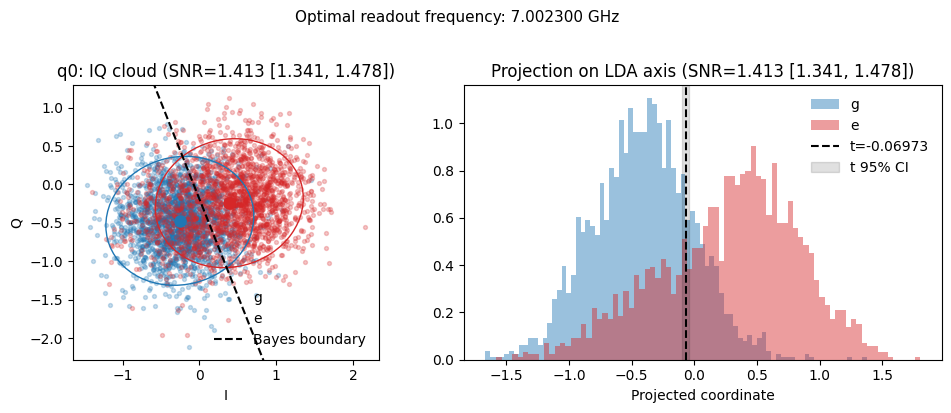

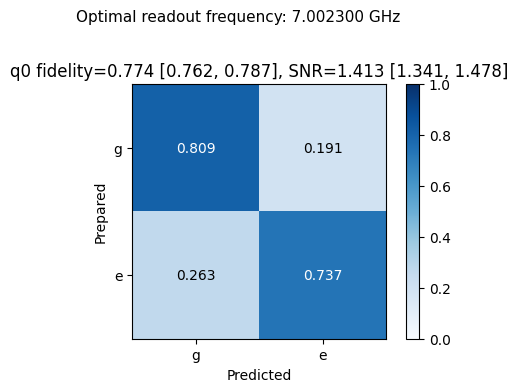

In [ ]:
from experiments import readout_frequency_sweep

# reuse q from previous cells if present; otherwise default to qubits[0]
try:
    q
except NameError:
    q = qubits[0]

base_f = float(q.parameters.readout_resonator_frequency)
frequencies = base_f + np.linspace(-1.0e6, 1.0e6, 11)

opts = readout_frequency_sweep.experiment_workflow.options()
opts.do_analysis(True)
opts.update(False)
opts.count(1024*2)

wf = readout_frequency_sweep.experiment_workflow(
    session=session,
    qpu=qpu,
    qubit=q,
    frequencies=frequencies,
    options=opts,
)
res_freq = wf.run()


print("[readout-frequency] quality:", ana_freq["quality_flag"])
pprint(ana_freq["best_point"])
pprint(ana_freq["new_parameter_values"])


In [ ]:
from experiments import (
    readout_integration_delay_sweep,
    readout_length_sweep,
    readout_amplitude_sweep,
)


def unwrap_output(obj):
    cur = obj
    for _ in range(16):
        if hasattr(cur, "output"):
            cur = cur.output
            continue
        return cur
    return cur


def extract_analysis_output(workflow_result):
    out = unwrap_output(workflow_result)
    if isinstance(out, dict) and "analysis_result" in out:
        analysis = unwrap_output(out["analysis_result"])
        if isinstance(analysis, dict):
            return analysis

    tasks = getattr(workflow_result, "tasks", None)
    if tasks is not None:
        try:
            for t in list(tasks):
                candidate = unwrap_output(getattr(t, "output", None))
                if isinstance(candidate, dict) and "best_point" in candidate:
                    return candidate
        except Exception:
            pass

    raise RuntimeError("Could not extract concrete analysis output.")


q = qubits[0]
print(f"Using qubit: {q.uid}")
print(
    "Current readout params:",
    {
        "readout_amplitude": q.parameters.readout_amplitude,
        "readout_length": q.parameters.readout_length,
        "readout_integration_length": q.parameters.readout_integration_length,
        "readout_integration_delay": q.parameters.readout_integration_delay,
    },
)


# Readout Integration Delay

In [ ]:
# 1) Integration delay + integration length optimization
base_delay = float(q.parameters.readout_integration_delay or 20e-9)
base_int_len = float(q.parameters.readout_integration_length)

delays = np.linspace(max(0.0, base_delay - 40e-9), base_delay + 80e-9, 13)
integration_lengths = base_int_len * np.array([0.6, 0.8, 1.0, 1.2])

opts = readout_integration_delay_sweep.experiment_workflow.options()
opts.do_analysis(True)
opts.update(False)
opts.count(512)

wf = readout_integration_delay_sweep.experiment_workflow(
    session=session,
    qpu=qpu,
    qubit=q,
    delays=delays,
    integration_lengths=integration_lengths,
    options=opts,
)
res_int = wf.run()
ana_int = extract_analysis_output(res_int)

print("[integration-window] quality:", ana_int["quality_flag"])
pprint(ana_int["best_point"])
pprint(ana_int["new_parameter_values"])


# Readout Length

In [ ]:
# 2) Readout length optimization

temporary_parameters = {}
temp_pars =deepcopy(q.parameters)
temporary_parameters[q.uid] = temp_pars
base_ro_len = float(q.parameters.readout_length)
readout_lengths = base_ro_len * np.array([0.5, 0.75, 1.0, 1.25, 1.5])

opts = readout_length_sweep.experiment_workflow.options()
opts.do_analysis(True)
opts.update(False)
opts.count(512)


wf = readout_length_sweep.experiment_workflow(
    session=session,
    qpu=qpu,
    qubit=q,
    readout_lengths=readout_lengths,
    options=opts,
)
res_len = wf.run()
ana_len = extract_analysis_output(res_len)

print("[readout-length] quality:", ana_len["quality_flag"])
pprint(ana_len["best_point"])
pprint(ana_len["new_parameter_values"])


In [ ]:
# 3) Readout amplitude optimization
# base_amp = float(q.parameters.readout_amplitude)
# amp_lo = max(0.05, 0.6 * base_amp)
# amp_hi = min(1.0, 1.3 * base_amp)
#amplitudes = np.linspace(amp_lo, amp_hi, 11)

temporary_parameters = {}
temp_pars =deepcopy(q.parameters)
temp_pars.readout_integration_length = 1e-6
temporary_parameters[q.uid] = temp_pars

amplitudes = np.linspace(0.0,0.5,31)

opts = readout_amplitude_sweep.experiment_workflow.options()
opts.do_analysis(True)
opts.update(False)
opts.count(1024*2)

wf = readout_amplitude_sweep.experiment_workflow(
    session=session,
    qpu=qpu,
    qubit=q,
    amplitudes=amplitudes,
    options=opts,
    temporary_parameters=temporary_parameters
)
res_amp = wf.run()
ana_amp = extract_analysis_output(res_amp)

print("[readout-amplitude] quality:", ana_amp["quality_flag"])
pprint(ana_amp["best_point"])
pprint(ana_amp["new_parameter_values"])


### Optional: apply updates
Set `opts.update(True)` in each workflow call to write selected values back into `qpu`.
